# Build a tile index csv and Mosaic Json for COGs

##### Path to your icesat2_boreal/lib dir - clone the icesat2_boreal GitHub repository
https://github.com/lauraduncanson/icesat2_boreal.git

In [1]:
ICESAT2_BOREAL_REPO_PATH = '/projects/Developer/icesat2_boreal' # /projects/Developer/icesat2_boreal/lib
ICESAT2_BOREAL_LIB_PATH = ICESAT2_BOREAL_REPO_PATH + '/lib'

In [2]:
try:
    import geopandas as gpd
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !pip install -U -r $ICESAT2_BOREAL_REPO_PATH/dps/requirements_main.txt
    
import geopandas
import pandas as pd
import os
import json
import collections
import numpy as np
import sys
import s3fs
import matplotlib.pyplot as plt
sys.path.append(ICESAT2_BOREAL_LIB_PATH)
import maplib_folium
import ExtractUtils
print("Importing packages complete.")

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Importing packages complete.


### Build the tile index csv

In [3]:
DPS_DATA_TYPE = 'AGB'#'HLS'
DPS_ALG_NAME = 'run_boreal_biomass_v5_ubuntu'#'do_HLS_stack_3-1-2_ubuntu'
DPS_RUN = '05'#'spring2022'

OUT_MASTER_CSV_JSON_DIR = '/projects/my-public-bucket/DPS_tile_lists/'+DPS_RUN
#OUT_MASTER_CSV_JSON_DIR = '/projects/my-public-bucket/DPS_tile_lists/HLS_test_redo/'+DPS_RUN
#DPS_DIR = 's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_v4_ubuntu/master/2022/norway_mask1'

tindex_master_fn        = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master.csv')
tile_matches_geojson_fn = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master.json')
out_mosaic_json_fn      = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master_mosaic.json')

In [4]:
#!python $ICESAT2_BOREAL_LIB_PATH/build_tindex_master.py --type ATL08_filt -m $DPS_RUN -o $OUT_MASTER_CSV_JSON_DIR

In [5]:
!python $ICESAT2_BOREAL_LIB_PATH/build_tindex_master.py --type $DPS_DATA_TYPE -alg_name $DPS_ALG_NAME -m $DPS_RUN -o $OUT_MASTER_CSV_JSON_DIR

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		AGB
Year:		2022
Month:		['05']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/05
bucket = s3://maap-ops-workspace
dps_out_searchkey_list = ['lduncanson/dps_output/run_boreal_biomass_v5_ubuntu/master/2022/05/01/**/*.tif', 'lduncanson/dps_output/run_boreal_biomass_v5_ubuntu/master/2022/05/02/**/*.tif', 'lduncanson/dps_output/run_boreal_biomass_v5_ubuntu/master/2022/05/03/**/*.tif', 'lduncanson/dps_output/run_boreal_biomass_v5_ubuntu/master/2022/05/04/**/*.tif', 'lduncanson/dps_output/run_boreal_biomass_v5_ubuntu/master/2022/05/05/**/*.tif', 'lduncanson/dps_output/run_boreal_biomass_v5_ubuntu/master/2022/05/06/**/*.tif', 

In [6]:
tindex_master = pd.read_csv(tindex_master_fn)
tindex_master.head()
len(tindex_master)

4578

In [7]:
tindex_master_fn

'/projects/my-public-bucket/DPS_tile_lists/05/AGB_tindex_master.csv'

### Get all boreal tiles

In [8]:
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 
boreal_tile_index = geopandas.read_file(boreal_tile_index_path)

boreal_tile_index["tile_num"] = boreal_tile_index["tile_num"].astype(int)

#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
#boreal_tile_index.plot(column='tile_num', linewidth=0.1, legend=True, ax=ax, cmap='Spectral')

### Find tiles needed for target DPS data type

                      count
tile_group                 
alaska extra             20
canada extra             49
conus extra              98
eurasia central        1169
eurasia east           1098
eurasia north           159
eurasia west            612
europe north            358
fennoscand south         26
north america centra    714
north america east      494
north america west      470
uk                       70
Tile status report for AGB from /projects/my-public-bucket/DPS_tile_lists/05/AGB_tindex_master.csv:
	# of boreal tiles in boreal v003:			5337
	# of boreal tiles in water:				0
	# of boreal tiles used study (from Topo coverage):	5337
	# of boreal tiles with AGB:				4578
	# of boreal tiles still needing AGB from all:	759


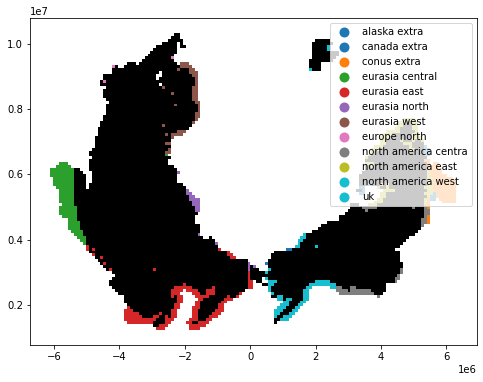

In [9]:
TILES_NEEDED = ExtractUtils.GET_TILES_NEEDED(DPS_DATA_TYPE = DPS_DATA_TYPE, \
                                                tindex_master_fn = tindex_master_fn,\
                                                 USER='nathanmthomas', \
                                                 TYPE = 'public', \
                                                boreal_tile_index_path = boreal_tile_index_path)

In [10]:
BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004]

# For the tindex_master, convert it into vector tiles that show the tiles we have
cols_list = ['tile_num','s3_path','local_path']

# Select the rows we have results for
tile_index_matches = boreal_tile_index.merge(tindex_master[~tindex_master['tile_num'].isin(BAD_TILE_LIST)][cols_list], how='right', on='tile_num')
tile_index_matches = tile_index_matches[tile_index_matches['s3_path'].notna()]
tile_index_matches.head()

,tile_num,tile_version,tile_group,map_version,geometry,s3_path,local_path
0,2339,version 1,eurasia central,None,"POLYGON ((-2511478.000 4293304.000, -2421478.0...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_bor...
1,2139,version 1,north america centra,None,"POLYGON ((3878522.000 4563304.000, 3968522.000...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_bor...
2,2765,version 1,north america centra,None,"POLYGON ((3248522.000 3843304.000, 3338522.000...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_bor...
3,3153,version 1,eurasia east,None,"POLYGON ((-1881478.000 3393304.000, -1791478.0...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_bor...
4,2152,version 1,north america centra,None,"POLYGON ((5048522.251 4563304.022, 5138522.253...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_bor...


## Build a MosaicJSON

##### Build tile geojsons needed for mosaic jsons

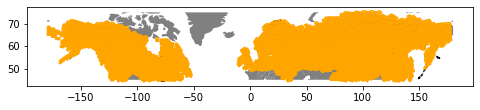

In [11]:
import shapely
# Corrections were made to ensure GeoJSON *_tindex_master.json was set correctly to 4326
tile_matches_geojson_string = tile_index_matches.to_crs("EPSG:4326")

#Write copy to disk for debug 
tile_matches_geojson_string.to_file(tile_matches_geojson_fn, driver='GeoJSON')

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres") )

# Create a custom polygon
polygon = shapely.geometry.Polygon([(-180, 45), (-180, 75), (180, 75), (180, 45), (-180, 45)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
#poly_gdf.plot()
world_clip = geopandas.clip(world, poly_gdf)
ax = world_clip.plot(color='gray')

boreal = geopandas.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')
ax = boreal.boundary.plot(color='black', ax=ax)
tile_matches_geojson_string.boundary.plot(color='orange', ax=ax)

tile_matches_geojson_string = tile_matches_geojson_string.to_json()

# This is formatted nicely (printed)
tile_matches_geojson = json.loads(tile_matches_geojson_string)

Map a subset (intersecting 45-75N) of these tiles for a paper figure

In [12]:
tmp = boreal_tile_index.to_crs(4326)

selector = tmp.intersects(world_clip.geometry)
tiles_subset = tmp[selector]
tiles_subset

/opt/conda/lib/python3.7/site-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


,tile_num,tile_version,tile_group,map_version,geometry
110,111,version 1,eurasia west,None,"POLYGON ((13.85443 63.23479, 12.40400 63.72105..."
120,121,version 1,eurasia west,None,"POLYGON ((27.10407 58.26161, 26.07842 58.86433..."


In [13]:

from typing import Dict
from cogeo_mosaic.mosaic import MosaicJSON
from cogeo_mosaic.backends import MosaicBackend

def get_accessor(feature: Dict):
    """Return specific feature identifier."""
    return feature["properties"]["s3_path"]

#out_mosaic_json_fn = f's3://maap-ops-workspace/shared/{DPS_DATA_USER}/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master_mosaic.json' 
#out_mosaic_json_fn = f's3://maap-ops-workspace/shared/alexdevseed/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master_mosaic.json' 

print(f"Building {out_mosaic_json_fn}")
mosaicdata = MosaicJSON.from_features(tile_matches_geojson.get('features'), minzoom=6, maxzoom=18, accessor=get_accessor)

with MosaicBackend(out_mosaic_json_fn, mosaic_def=mosaicdata) as mosaic:
    mosaic.write(overwrite=True)

Building /projects/my-public-bucket/DPS_tile_lists/05/AGB_tindex_master_mosaic.json


/projects/.local/lib/python3.7/site-packages/mercantile/__init__.py:79: FutureWarning: Mercantile 2.0 will require tile x and y to be within the range (0, 2 ** zoom)
  FutureWarning,


### Build a mosaic json of a test local tile

In [14]:
if False:
    TEST_TILE_NUM = 42 #3000

    # -- Adjust this manually
    tmp = boreal_tile_index[boreal_tile_index.tile_num == TEST_TILE_NUM]
    #tmp['s3_path'] = f's3://maap-ops-workspace/shared/nathanmthomas/test_hls/test_mc40_3yrs/HLS_{TEST_TILE_NUM}_06-01_09-15_2019_2021.tif'
    tmp['s3_path'] =  f's3://maap-ops-workspace/shared/lduncanson/testing/output/boreal_agb_202205041651688894_00{TEST_TILE_NUM}.tif'
    #out_mosaic_json_TEST_fn = f'/projects/my-public-bucket/test_hls/test_mc40_3yrs/HLS_tile_test_mosaic_tile_{TEST_TILE_NUM}.json'

    tile_matches_geojson_TEST_fn = f'/projects/my-public-bucket/TEST_tindex_{TEST_TILE_NUM}.json'
    out_mosaic_json_TEST_fn = f'/projects/my-public-bucket/TEST_tindex_mosaic_{TEST_TILE_NUM}.json'
    # --


    # Corrections were made to ensure GeoJSON *_tindex_master.json was set correctly to 4326
    tile_matches_geojson_string = tmp.to_crs("EPSG:4326")

    #Write copy to disk for debug 
    tile_matches_geojson_string.to_file(tile_matches_geojson_TEST_fn, driver='GeoJSON')

    tile_matches_geojson_string.plot()
    tile_matches_geojson_string = tile_matches_geojson_string.to_json()

    # This is formatted nicely (printed)
    tile_matches_geojson = json.loads(tile_matches_geojson_string)

    print(f"Building {out_mosaic_json_TEST_fn}")
    mosaicdata = MosaicJSON.from_features(tile_matches_geojson.get('features'), minzoom=6, maxzoom=18, accessor=get_accessor)

    with MosaicBackend(out_mosaic_json_TEST_fn, mosaic_def=mosaicdata) as mosaic:
        mosaic.write(overwrite=True)

    out_mosaic_json_TEST_fn